## Neural network for sector classification
The neural network maps the company sectors to the descriptions.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [2]:
def df_to_dataset(dataframe, column, shuffle=True, batch_size=64):
    """Convert the Pandas' dataset into a tensorflow dataset and shuffle and batch the entries."""
    df = dataframe.copy()
    code = df.pop('code')
    df = dataframe[f'{column}']
    ds = tf.data.Dataset.from_tensor_slices((df, code))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(dataframe))
    ds = ds.batch(batch_size)
    return ds

### Dataset with normal sentences

In [3]:
column = 'description'

df = pd.read_json('..\\data_prep.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,description,sector,code
0,Adara Acquisition Corp. does not have signific...,Financial Services,5
1,"AIM ImmunoTech Inc., an immuno-pharma company,...",Healthcare,6
2,"Ashford, Inc is an asset management firm. The ...",Financial Services,5
3,"The Arena Group Holdings, Inc., together with ...",Communication Services,1
4,"AMCON Distributing Company, together with its ...",Consumer Defensive,3


In [4]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [6]:
train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [7]:
# import a token based text embedding on English Google News with pre-built out-of-vocabulary handling
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [8]:
# built a neural network for classification with kernel regularization to decrease overfitting
model = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(10, activation='softmax')
])

In [9]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# set early stopping
es = EarlyStopping(patience=1, verbose=1, restore_best_weights=True)

In [10]:
# train the model and use early stopping
history = model.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    callbacks=[es])

Epoch 1/20
123/123 [==============================] - 49s 395ms/step - loss: 2.0370 - accuracy: 0.4778 - val_loss: 1.8456 - val_accuracy: 0.4949
Epoch 2/20
123/123 [==============================] - 48s 393ms/step - loss: 1.2909 - accuracy: 0.6944 - val_loss: 1.4491 - val_accuracy: 0.6781
Epoch 3/20
123/123 [==============================] - 49s 396ms/step - loss: 0.8633 - accuracy: 0.8705 - val_loss: 1.2163 - val_accuracy: 0.7520
Epoch 4/20
123/123 [==============================] - 48s 393ms/step - loss: 0.6432 - accuracy: 0.9210 - val_loss: 1.1525 - val_accuracy: 0.7611
Epoch 5/20
123/123 [==============================] - 48s 393ms/step - loss: 0.5217 - accuracy: 0.9538 - val_loss: 1.1255 - val_accuracy: 0.7611
Epoch 6/20
123/123 [==============================] - 48s 393ms/step - loss: 0.4423 - accuracy: 0.9749 - val_loss: 1.0901 - val_accuracy: 0.7672
Epoch 7/20
123/123 [==============================] - 48s 394ms/step - loss: 0.3855 - accuracy: 0.9860 - val_loss: 1.0987 - val_ac

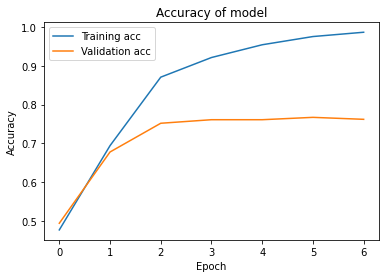

In [11]:
plt.plot(history.history['accuracy'], label="Training acc")
plt.plot(history.history['val_accuracy'], label="Validation acc")
plt.title("Accuracy of model")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.show()

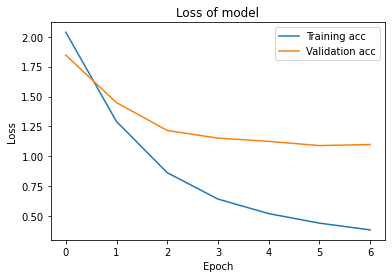

In [12]:
plt.plot(history.history['loss'], label="Training acc")
plt.plot(history.history['val_loss'], label="Validation acc")
plt.title("Loss of model")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend()
plt.show()

In [13]:
model.evaluate(test_data)

16/16 [==============================] - 1s 46ms/step - loss: 0.8980 - accuracy: 0.7862


[0.8979877829551697, 0.7861506938934326]

## Dataset without stopwords and lemmatization

In [3]:
column = 'explicit_lemmatization'

df = pd.read_json('..\\Unternehmen_preprocessed.json')
df.sector = pd.Categorical(df.sector)
df['code'] = df.sector.cat.codes
df.head()

,name,ticker,sector,description,rough_lemmatization,explicit_lemmatization,search_engine,code
0,Adara Acquisition Corp.,ADRA,Financial Services,Adara Acquisition Corp. does not have signific...,Adara Acquisition Corp. significant operation ...,significant operation company intend effect me...,SIGNIFICANT OPERATION COMPANY INTEND EFFECT ME...,5
1,AIM ImmunoTech Inc.,AIM,Healthcare,"AIM ImmunoTech Inc., an immuno-pharma company,...",AIM ImmunoTech Inc. immuno pharma company focu...,immuno pharma company focus research developme...,IMMUNO PHARMA COMPANY FOCUS RESEARCH DEVELOPME...,6
2,Ashford Inc.,AINC,Financial Services,"Ashford, Inc is an asset management firm. The ...",Ashford Inc asset management firm firm provide...,Ashford Inc asset management firm firm provide...,ASHFORD INC ASSET MANAGEMENT FIRM FIRM PROVIDE...,5
3,"The Arena Group Holdings, Inc.",AREN,Communication Services,"The Arena Group Holdings, Inc., together with ...",Arena Group Holdings Inc. subsidiary operate d...,subsidiary operate digital medium platform Uni...,SUBSIDIARY OPERATE DIGITAL MEDIUM PLATFORM UNI...,1
4,AMCON Distributing Company,DIT,Consumer Defensive,"AMCON Distributing Company, together with its ...",AMCON distribute Company subsidiary engage who...,subsidiary engage wholesale distribution consu...,SUBSIDIARY ENGAGE WHOLESALE DISTRIBUTION CONSU...,3


In [4]:
# stratify the sectors evenly onto train, val and test dataset
grouped_df = df.groupby('sector')
arr_list = [np.split(g, [int(.8 * len(g)), int(.9 * len(g))]) for i, g in grouped_df]
train = pd.concat([t[0] for t in arr_list])
val = pd.concat([v[2] for v in arr_list])
test = pd.concat([t[1] for t in arr_list])

In [5]:
train_data = df_to_dataset(train, column)
valid_data = df_to_dataset(val, column)
test_data = df_to_dataset(test, column)

In [6]:
# import a token based text embedding on English Google News with pre-built out-of-vocabulary handling
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"

In [7]:
# built a neural network for classification with kernel regularization to decrease overfitting
model_lemma = tf.keras.Sequential([
    hub.KerasLayer(embedding, dtype=tf.string, trainable=True),
    Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(11, activation='softmax')
])

In [8]:
model_lemma.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# set early stopping
es = EarlyStopping(patience=1, verbose=1, restore_best_weights=True)

In [10]:
# train the model and use early stopping
history_lemma = model_lemma.fit(train_data,
                    validation_data=valid_data,
                    epochs=20,
                    callbacks=[es])

Epoch 1/20
123/123 [==============================] - 49s 396ms/step - loss: 2.1702 - accuracy: 0.4907 - val_loss: 1.6584 - val_accuracy: 0.6555
Epoch 2/20
123/123 [==============================] - 50s 404ms/step - loss: 1.1503 - accuracy: 0.7946 - val_loss: 1.2430 - val_accuracy: 0.7710
Epoch 3/20
123/123 [==============================] - 49s 398ms/step - loss: 0.8192 - accuracy: 0.8794 - val_loss: 1.1049 - val_accuracy: 0.7680
Epoch 4/20
123/123 [==============================] - 48s 394ms/step - loss: 0.6502 - accuracy: 0.9212 - val_loss: 1.0082 - val_accuracy: 0.7974
Epoch 5/20
123/123 [==============================] - 48s 394ms/step - loss: 0.5448 - accuracy: 0.9453 - val_loss: 0.9543 - val_accuracy: 0.8156
Epoch 6/20
123/123 [==============================] - 48s 394ms/step - loss: 0.4717 - accuracy: 0.9643 - val_loss: 0.9366 - val_accuracy: 0.8014
Epoch 7/20
123/123 [==============================] - 48s 394ms/step - loss: 0.4163 - accuracy: 0.9739 - val_loss: 0.9063 - val_ac

In [11]:
model_lemma.evaluate(test_data)

16/16 [==============================] - 1s 47ms/step - loss: 0.7903 - accuracy: 0.8308


[0.7902708649635315, 0.8307849168777466]